# This is the procession of downstream analysis

In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import pytometry as pm
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from matplotlib import rcParams
from matplotlib import colors
sc.logging.print_versions()
sc.settings.verbosity = 3
import matplotlib as mpl
import os 
import pickle
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['font.family'] = 'sans-serif'
rcParams["figure.figsize"] = (5, 5)
rcParams["figure.dpi"] = 400
pl.rcParams.update(mpl.rcParams)

/home/lx/miniforge3/envs/SingleCell/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
anndata     0.10.9
scanpy      1.10.3
-----
PIL                         10.4.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        25.3.0
attrs                       25.3.0
babel                       2.16.0
brotli                      1.1.0
certifi                     2025.06.15
cffi                        1.17.0
charset_normalizer          3.3.2
colorama                    0.4.6
comm                        0.2.2
consensusclustering         NA
cupy                        13.3.0
cupy_backends               NA
cupyx                       NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.14
decorator                   5.2.1
defusedxml                  0.7.1
executing                   2.2.0
fastjsonschema              NA
fastrlock                   0.8.2
fcsparser                   0.2.8
flowutils                   1.1.0


/home/lx/miniforge3/envs/SingleCell/lib/python3.12/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


## Load the data

In [2]:
adata_selected_marker_synthetic = sc.read("../data/GenerateCellMarker.h5ad")

## Leiden clustering

In [3]:
sc.pp.pca(adata_selected_marker_synthetic)
sc.pp.neighbors(adata_selected_marker_synthetic, n_neighbors=10, n_pcs=0)
resolutions = (0.6,)
leiden_results = {}
for res in resolutions:
    sc.tl.leiden(adata_selected_marker_synthetic, resolution=res, random_state=0, flavor="igraph", n_iterations=2, directed=False)
    leiden_results[res] = adata_selected_marker_synthetic.obs['leiden'].copy()
    colors2 = pl.cm.Reds(np.linspace(0, 1, 80))
    colors3 = pl.cm.Greys_r(np.linspace(0.7, 0.8, 10))
    colorsComb = np.vstack([colors3, colors2])
    mymap = colors.LinearSegmentedColormap.from_list("my_colormap", colorsComb)

computing PCA
    with n_comps=11
    finished (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)
running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


## Cell annotation and the protein expression

In [4]:
with open("cluster2cell.pkl", "rb") as f:
    cluster2cell = pickle.load(f)
adata_selected_marker_synthetic.obs["cell_type_lvl2"] = adata_selected_marker_synthetic.obs["leiden"].map(cluster2cell).copy()

/tmp/ipykernel_170019/1450599628.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blue_red_cmap = pl.cm.get_cmap("RdYlBu_r")


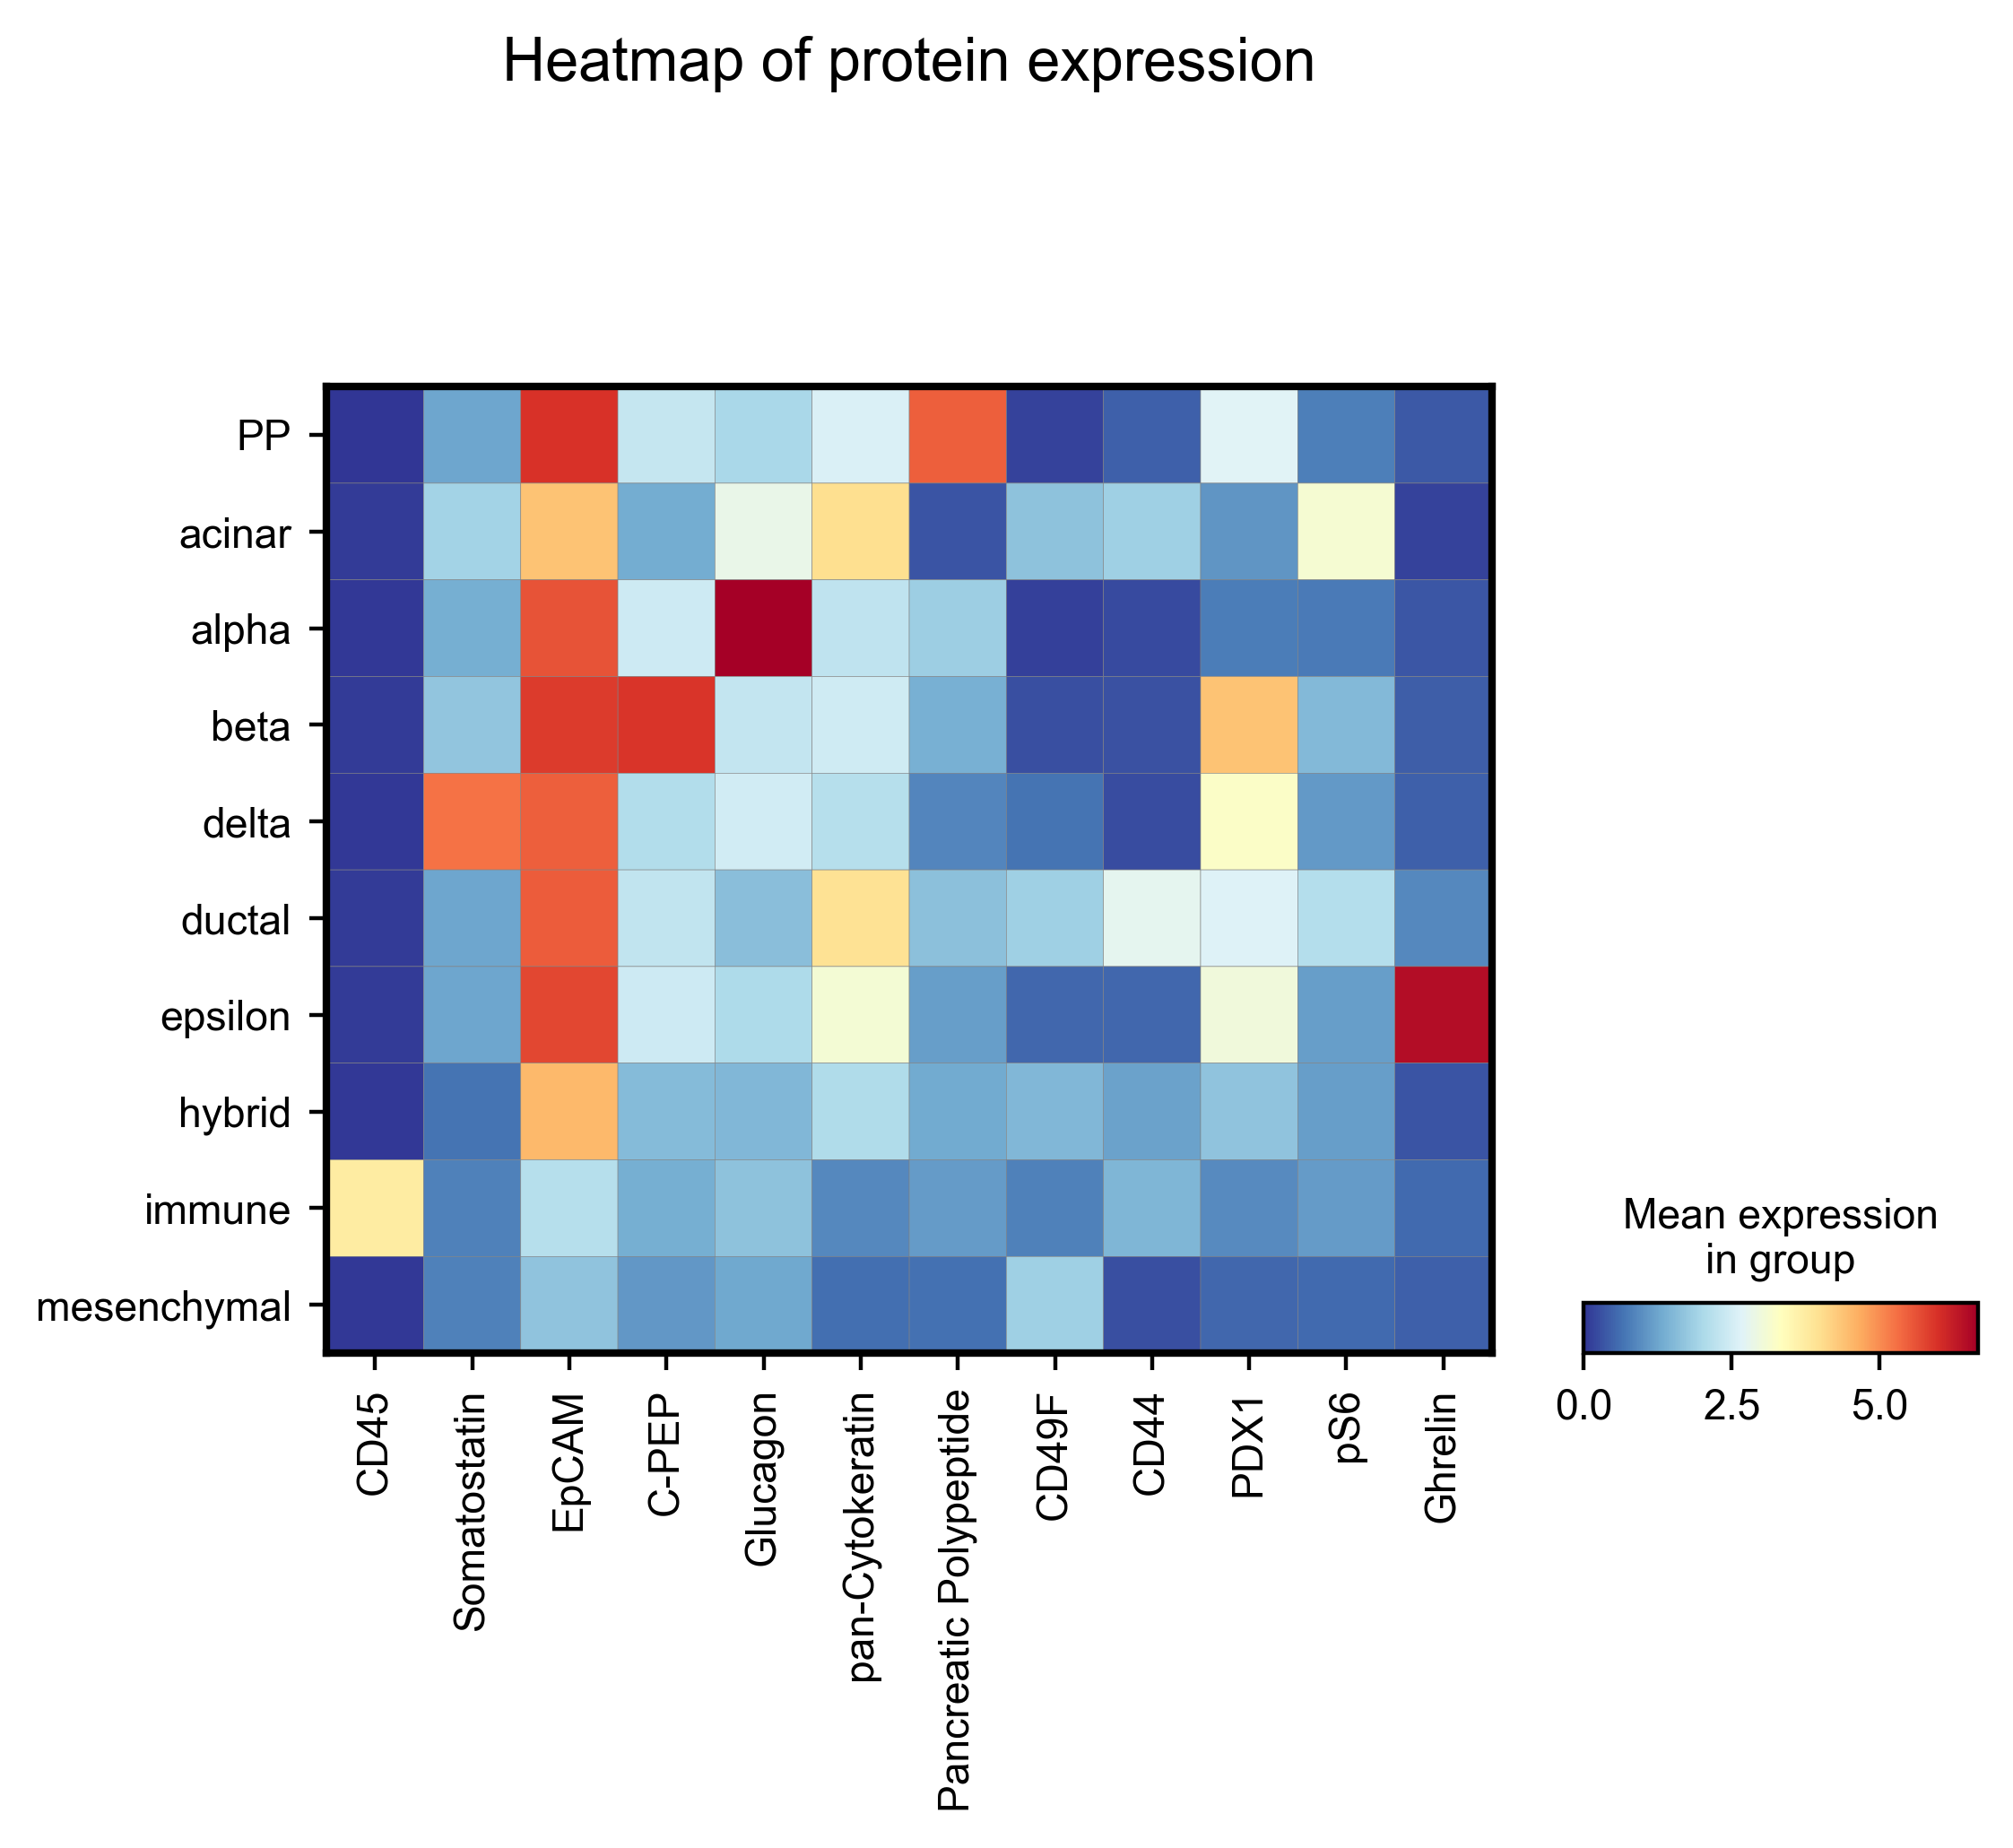

In [5]:
blue_red_cmap = pl.cm.get_cmap("RdYlBu_r")
sc.pl.matrixplot(
    adata_selected_marker_synthetic,
    groupby="cell_type_lvl2",
    var_names=list(adata_selected_marker_synthetic.var.index),
    vmin=0,
    cmap=blue_red_cmap,
    title=f'Heatmap of protein expression',
    show=False
    )
pl.show()

## Celltype proportion

In [6]:
# Get the patient label
label_df = pd.read_excel('/home/lx/singleCell/SampleLabel.xlsx')
adata_selected_marker_synthetic.obs['sample'] = (
    adata_selected_marker_synthetic.obs['sample']
    .str.replace('.npy', '', regex=False)
)
adata_selected_marker_synthetic.obs['sample'] = adata_selected_marker_synthetic.obs['sample'].astype(str)
label_df['donor_ID'] = label_df['donor_ID'].astype(str)
adata_selected_marker_synthetic.obs = adata_selected_marker_synthetic.obs.merge(label_df[['donor_ID', 'clinical_diagnosis']], 
                                                            left_on='sample', right_on='donor_ID', 
                                                            how='left')
adata_selected_marker_synthetic.obs.rename(columns={'clinical_diagnosis': 'sampleCls'}, inplace=True)

In [7]:
cell_type_counts = adata_selected_marker_synthetic.obs.groupby(['sampleCls', 'cell_type_lvl2']).size().unstack(fill_value=0)
cell_type_proportions = cell_type_counts.div(cell_type_counts.sum(axis=1), axis=0)

cell_type_lvl2        PP    acinar     alpha      beta     delta    ductal  \
sampleCls                                                                    
Control         0.020526  0.079895  0.184895  0.245263  0.028789  0.176526   
T1D             0.006444  0.106222  0.408556  0.042556  0.032556  0.145000   

cell_type_lvl2   epsilon    hybrid    immune  mesenchymal  
sampleCls                                                  
Control         0.001737  0.200421  0.012737     0.049211  
T1D             0.001333  0.205333  0.013889     0.038111  


/tmp/ipykernel_170019/2249982454.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata_selected_marker_synthetic.obs.groupby(['sampleCls', 'cell_type_lvl2']).size().unstack(fill_value=0)


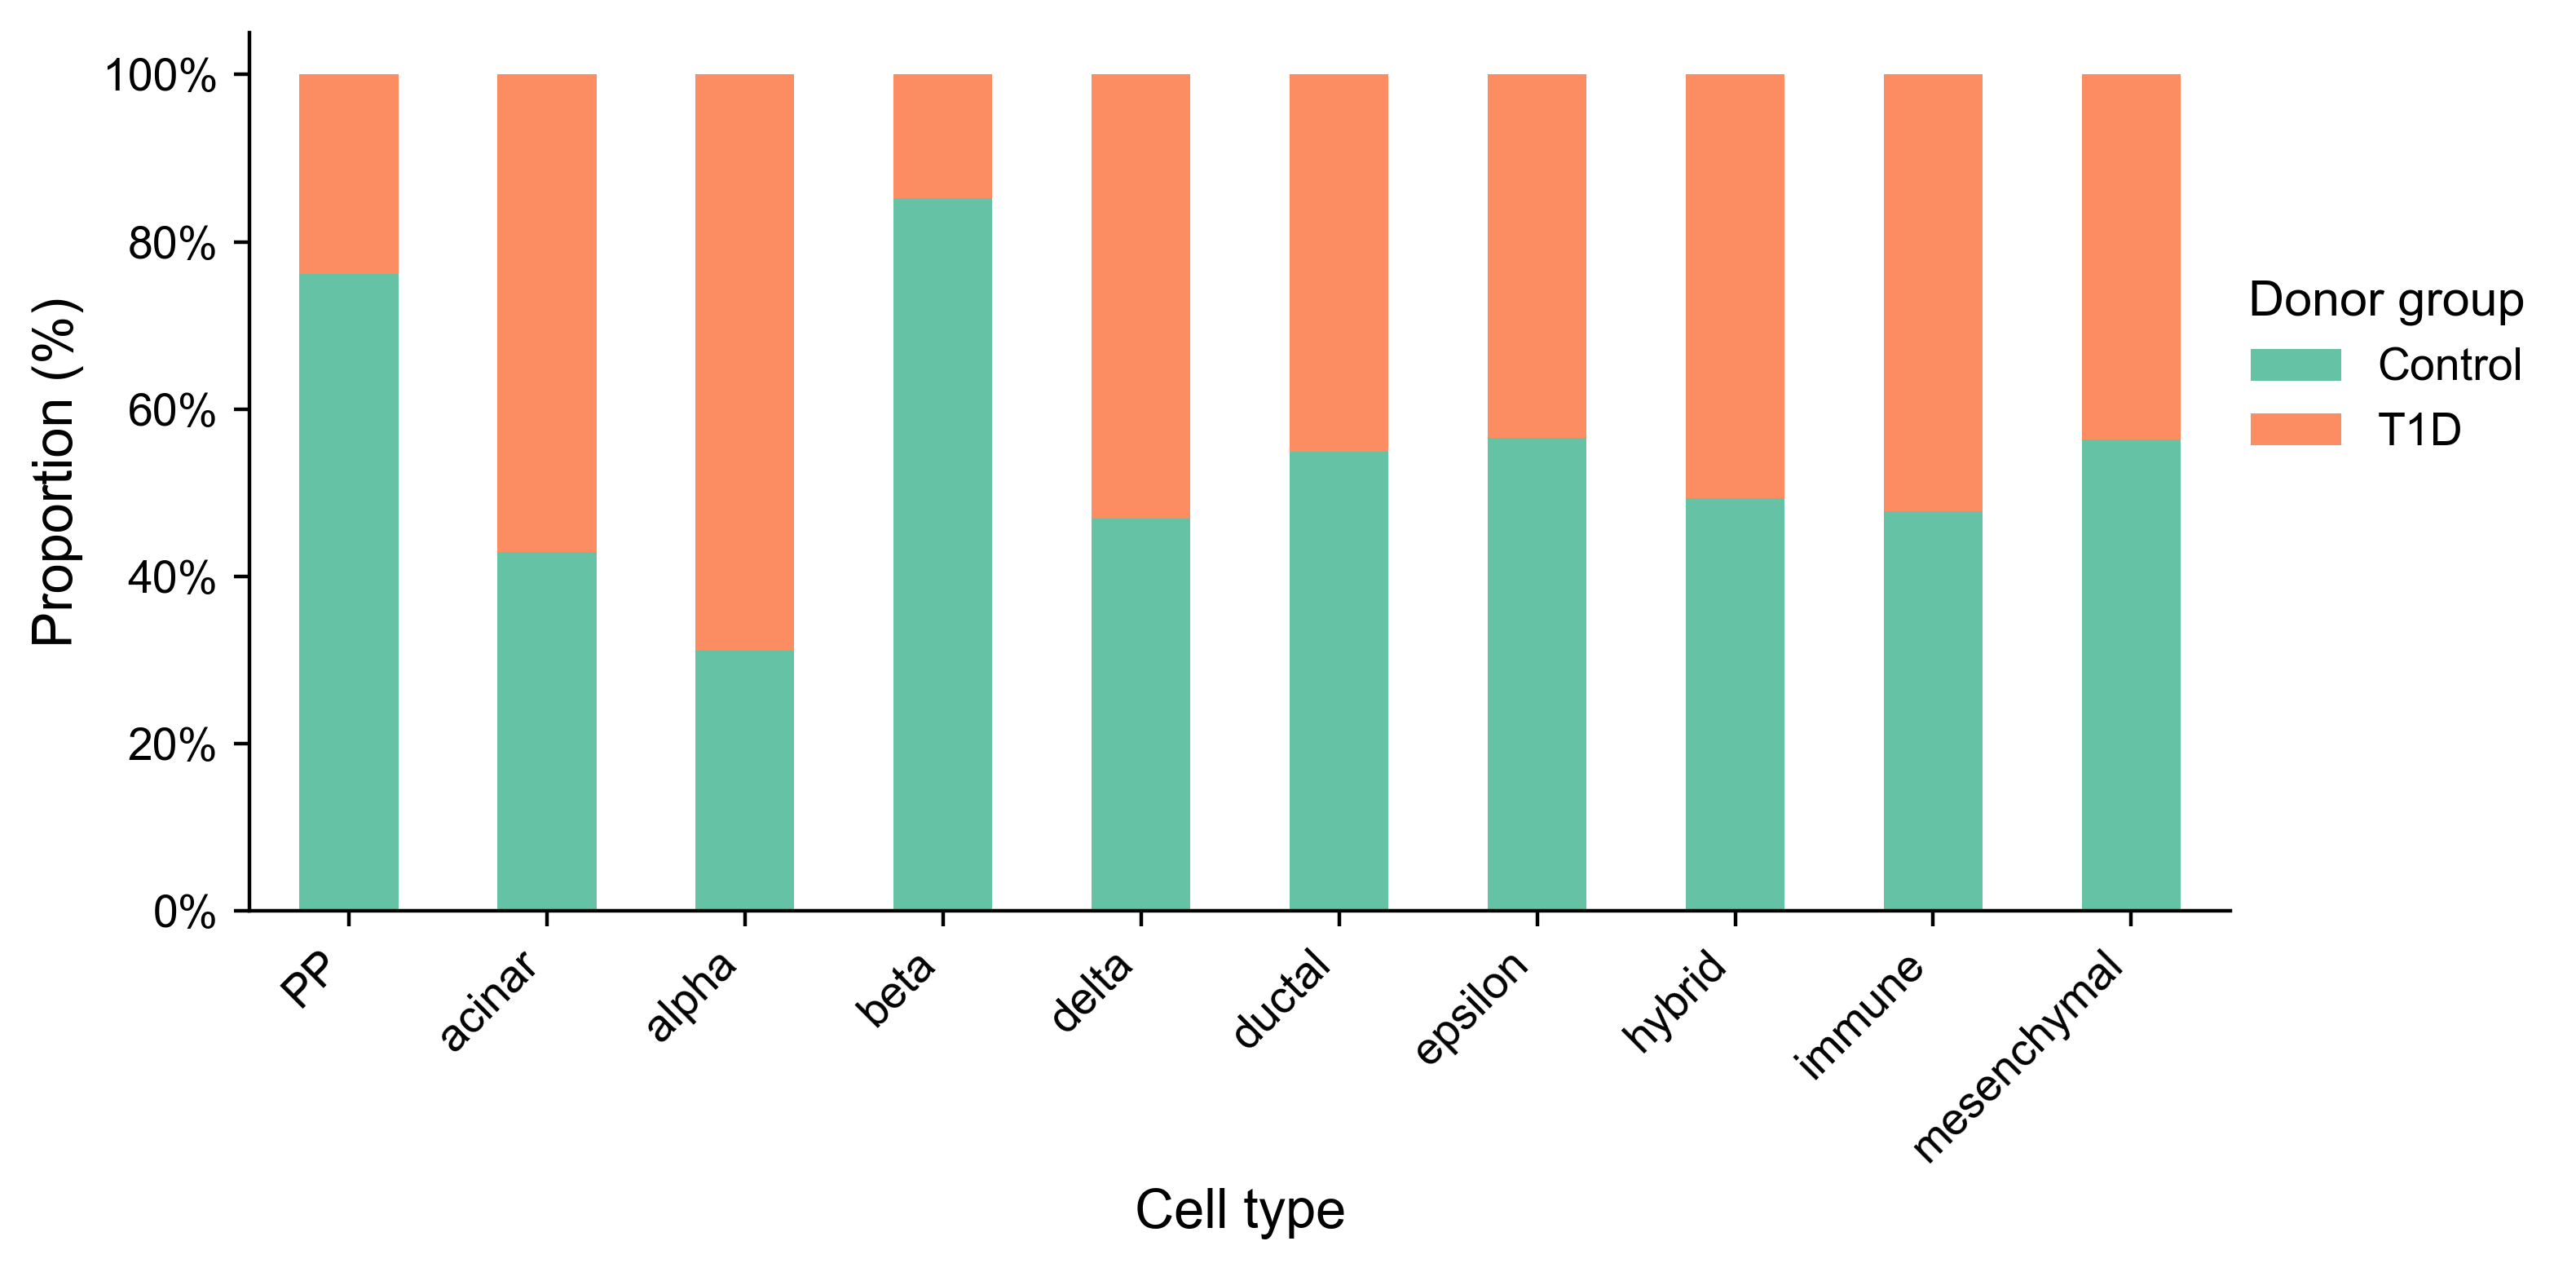

In [8]:
import matplotlib.pyplot as plt
normalized_proportions = cell_type_proportions.div(cell_type_proportions.sum(axis=0), axis=1)
target_cell_types = cell_type_counts.columns
filtered_proportions = normalized_proportions[target_cell_types]
fig, ax = plt.subplots(figsize=(8, 4),dpi=400)
cell_type_proportions.div(cell_type_proportions.sum(axis=0), axis=1).T.plot(
    kind="bar", stacked=True, ax=ax, color=["#66c2a5", "#fc8d62", "#8da0cb"], edgecolor="none"
)
ax.set_xlabel("Cell type",fontsize =12)
ax.set_ylabel("Proportion (%)",fontsize =12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_xticklabels(cell_type_proportions.columns, rotation=45, ha="right")
ax.legend(title="Donor group", loc=(1,0.5), frameon=False,title_fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()